## Module 5: Analyse, diagnose and improve a model​

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [170]:
technical_features = ['close_0', 'close_sp500_0', 'close_365', 'close_sp500_365',
       'close__minus_120', 'close_sp500__minus_120', 'close__minus_365',
       'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730',
       'stock_change_365','stock_change_div_365', 'sp500_change_365', 'stock_change__minus_120',
       'sp500_change__minus_120', 'stock_change__minus_365',
       'sp500_change__minus_365', 'stock_change__minus_730','sp500_change__minus_730',
       'std__minus_365','std__minus_730','std__minus_120']

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [171]:
import pandas as pd
import os
import re
import numpy as np
import lightgbm as lgb
import shap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip,geom_bar,scale_x_discrete, geom_point, theme,element_text, geom_line
from matplotlib import pyplot as plt

In [172]:
# number of trees in lightgbm
N_TREES = 40
N_ESTIMATORS = 300
MINIMUN_NUMBER_OF_TICKERS = 1500
# Number of the quarters in the past to train
N_TRAIN_QUARTES = 36
# number of tickers to make the portfolio
TOP_N = 10

In [173]:
data_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(''))), 'data', 'financials_against_return.feather')
raw_data_set = pd.read_feather(data_path)

Remove these quarters which have les than `minimum_number_of_tickers` tickers:

In [174]:
df_quarter_lengths = raw_data_set.groupby(["execution_date"]).size().reset_index().rename(columns = {0:"count"})
data_set = pd.merge(raw_data_set, df_quarter_lengths, on = ["execution_date"])
data_set = data_set[data_set["count"]>=MINIMUN_NUMBER_OF_TICKERS]

Create the target:

In [175]:
data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]

data_set.loc[data_set["diff_ch_sp500"]>0,"target"] = 1
data_set.loc[data_set["diff_ch_sp500"]<0,"target"] = 0

data_set["target"].value_counts()

target
0.0    82437
1.0    73829
Name: count, dtype: int64

In [176]:
data_set.shape

(170483, 146)

This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

In [177]:
def get_weighted_performance_of_stocks(df,metric):
    df["norm_prob"] = 1/len(df)
    return np.sum(df["norm_prob"]*df[metric])

def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert ("Not matching train/test")
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending = False)
    data_set = data_set.head(TOP_N)
    return data_set

# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return "weighted-return", get_weighted_performance_of_stocks(top_dataset,"diff_ch_sp500"), True


# My metrics
def pr_auc_metric(preds, train_data):
    labels = train_data.get_label()
    auc = average_precision_score(labels, preds)
    return "auc", auc, True

def roc_auc_metric(preds, train_data):
    labels = train_data.get_label()
    auc = roc_auc_score(labels, preds)
    return "roc_auc", auc, True

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [178]:
def split_train_test_by_period(data_set, test_execution_date,include_nulls_in_test = False):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[data_set["execution_date"] <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit = "day")]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if N_TRAIN_QUARTES!=None:
        train_set = train_set[train_set["execution_date"].isin(execution_dates[-N_TRAIN_QUARTES:])]
        
    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values('date', ascending = False).drop_duplicates('Ticker', keep = 'first')
    
    return train_set, test_set

Ensure that we don't include features which are irrelevant or related to the target:

In [179]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_730", # Added, was making data leak
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
        
    return columns_to_remove

This is the main modeling function, it receives a train set and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [180]:
import warnings
warnings.filterwarnings('ignore')


def train_model(
        train_set, test_set, n_estimators=N_ESTIMATORS
    ):
    columns_to_remove = get_columns_to_remove()

    X_train = train_set.drop(columns=columns_to_remove, errors="ignore")
    X_test = test_set.drop(columns=columns_to_remove, errors="ignore")

    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

    eval_result = {}

    objective = 'binary'
    metric = 'binary_logloss'
    params = {
        "random_state": 1,
        "verbosity": -1,
        "n_jobs": 10,
        "n_estimators": n_estimators,
        "objective": objective,
        "metric": metric
    }

    model = lgb.train(
        params=params,
        train_set=lgb_train,
        valid_sets=[lgb_test, lgb_train],
        feval=[top_wt_performance, pr_auc_metric, roc_auc_metric],
        callbacks=[lgb.record_evaluation(eval_result=eval_result)]
    )
    return model, eval_result, X_train, X_test


 
            

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [181]:
def run_model_for_execution_date(
            execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,
            include_nulls_in_test = False
        ):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None
        
        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model(train_set,
                                                              test_set,
                                                              n_estimators = n_estimators)
            
            test_set['prob'] = model.predict(X_test)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)
        return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test


execution_dates = np.sort( data_set['execution_date'].unique() )


This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [182]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    print(execution_date)
    (
        all_results,all_predicted_tickers_list,all_models,model,X_train,X_test
    ) = run_model_for_execution_date(
            execution_date,all_results,all_predicted_tickers_list,all_models,N_TREES,False
        )
    
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [183]:
def parse_results_into_df(set_, results=all_results):
    df = pd.DataFrame()
    for date in results:
        df_tmp = pd.DataFrame(results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df= pd.concat([df,df_tmp])
    
    df["execution_date"] = df["execution_date"].astype(str)
    
    return df

In [184]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [185]:
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

And this are the results:

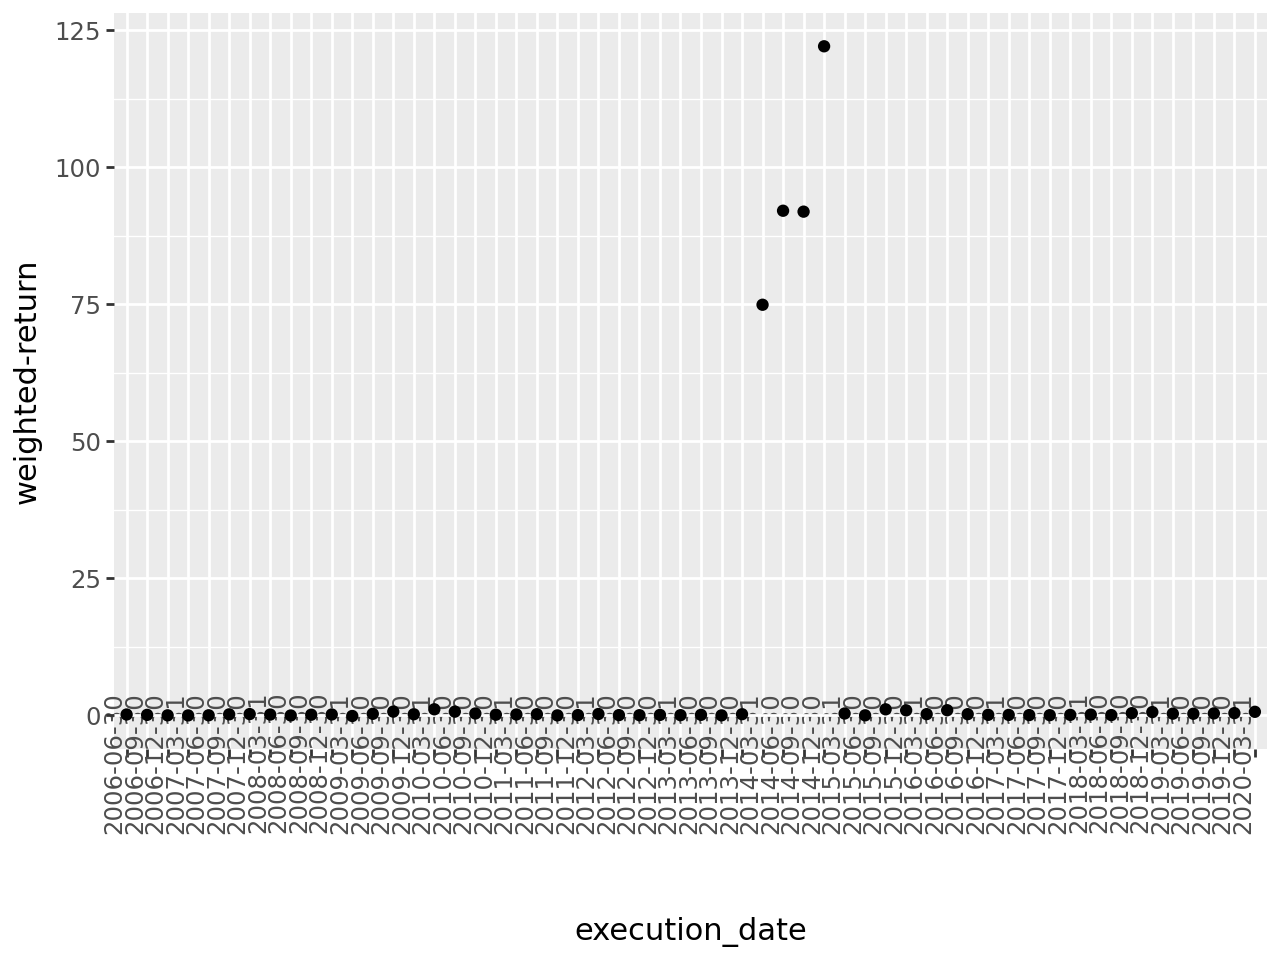

In [186]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

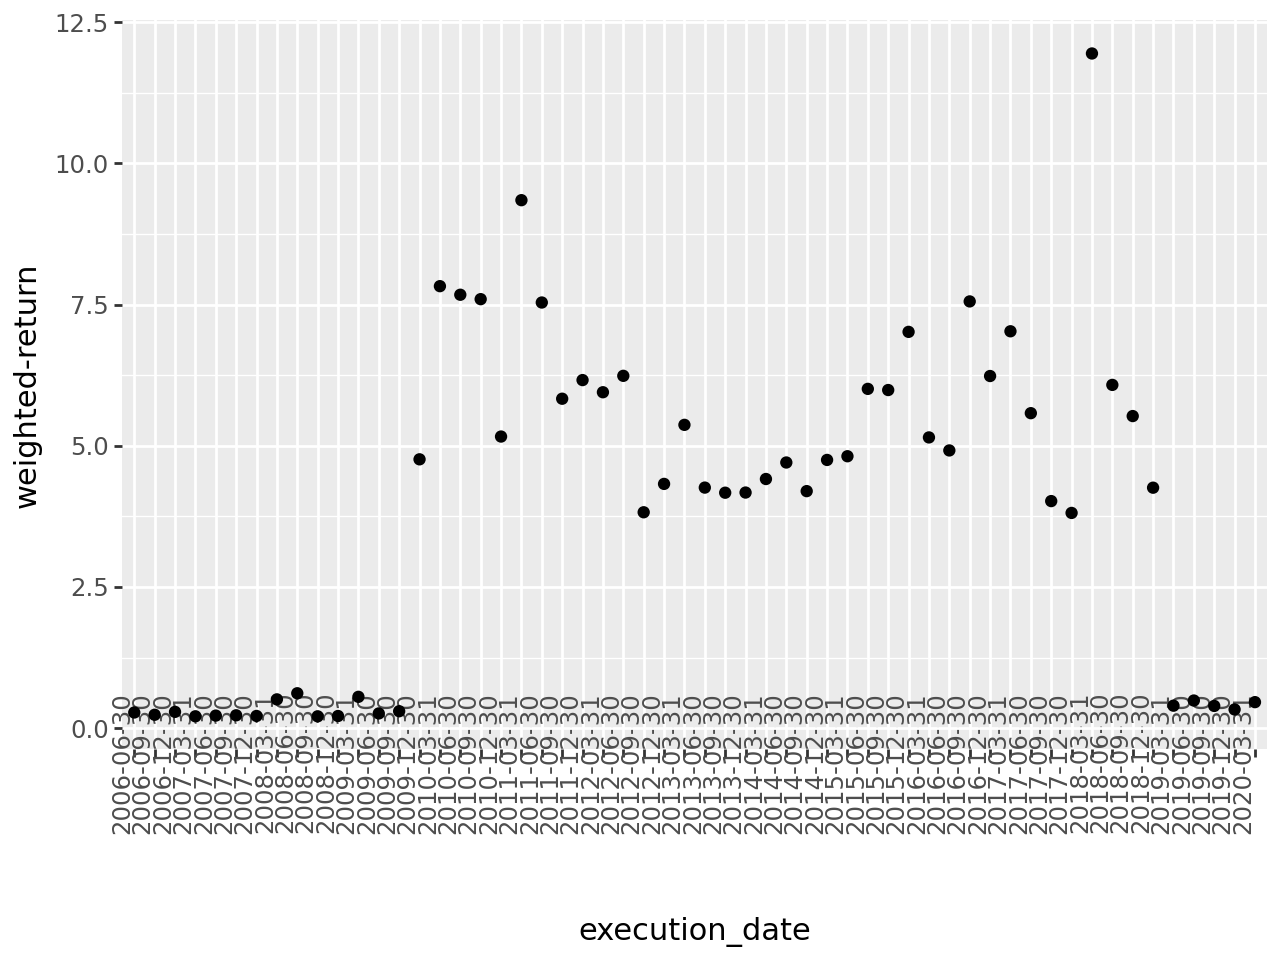

In [187]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* Try to see if there is any kind of data leakage or suspicious features
* If the training part is very slow, try to see how you can modify it to execute faster tests
* Try to understand if the algorithm is learning correctly
* We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones
* Try to see if there is overfitting
* Try to see if there is a lot of noise between different trainings
* To simplify, why if you only keep the first tickers in terms of Market Cap?
* Change the number of quarters to train in the past

This function can be useful to compute the feature importance:

In [188]:
def draw_feature_importance(model,top = 15):
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame([{"feature":fn[i],"imp":fi[i]} for i in range(len(fi))])
    feature_importance = feature_importance.sort_values("imp",ascending = False).head(top)
    feature_importance = feature_importance.sort_values("imp",ascending = True)
    plot = ggplot(feature_importance,aes(x = "feature",y  = "imp")) + geom_col(fill = "lightblue") + coord_flip() +  scale_x_discrete(limits = feature_importance["feature"])
    return plot


---

## My Exploration

### About the Custom Metric

I believe that the business metric, as currently implemented, does not make logical sense when applied to the training set, because:

- It takes predictions for a specific `execution_date`
- Sorts tickers by predicted probability
- Selects the TOP_N tickers
- Calculates the average return of that "portfolio"

When evaluating on the training set:
- We have data from multiple `execution_date`s (36 historical quarters)
- The model predicts on all these quarters mixed together
- Then it selects the TOP_N tickers with the highest probability, regardless of the quarter
- This does not simulate a real investment decision

To properly compare predictions on train and test, it would be better to look at other metrics such as:
- LogLoss
- ROC-AUC
- PR-AUC

The business metric only makes sense when evaluating tickers for a specific `execution_date`.

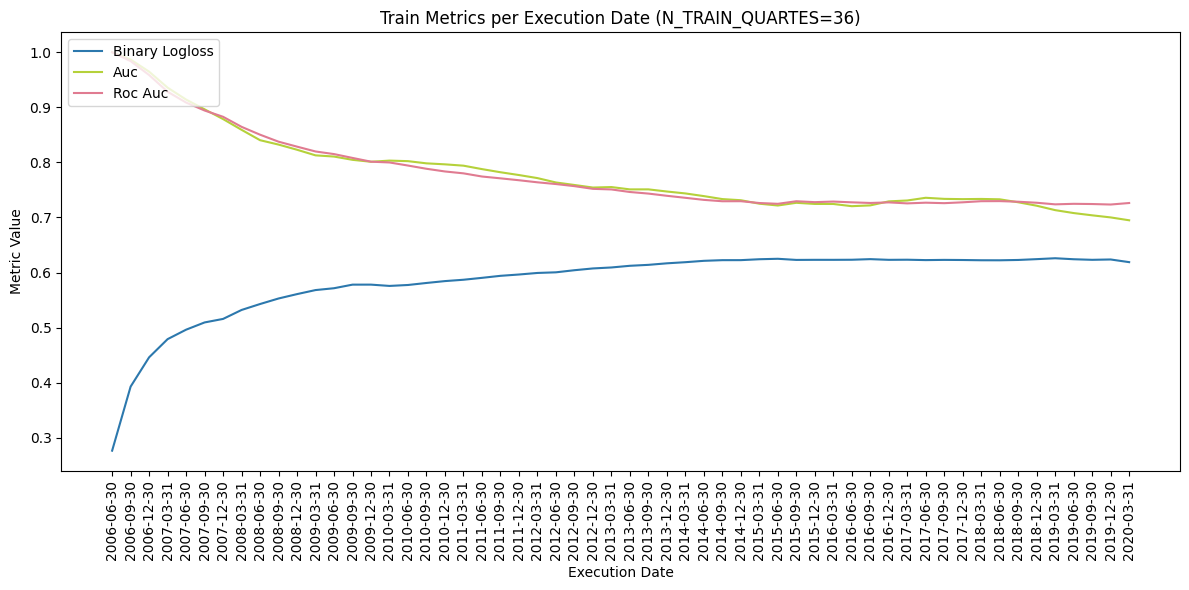

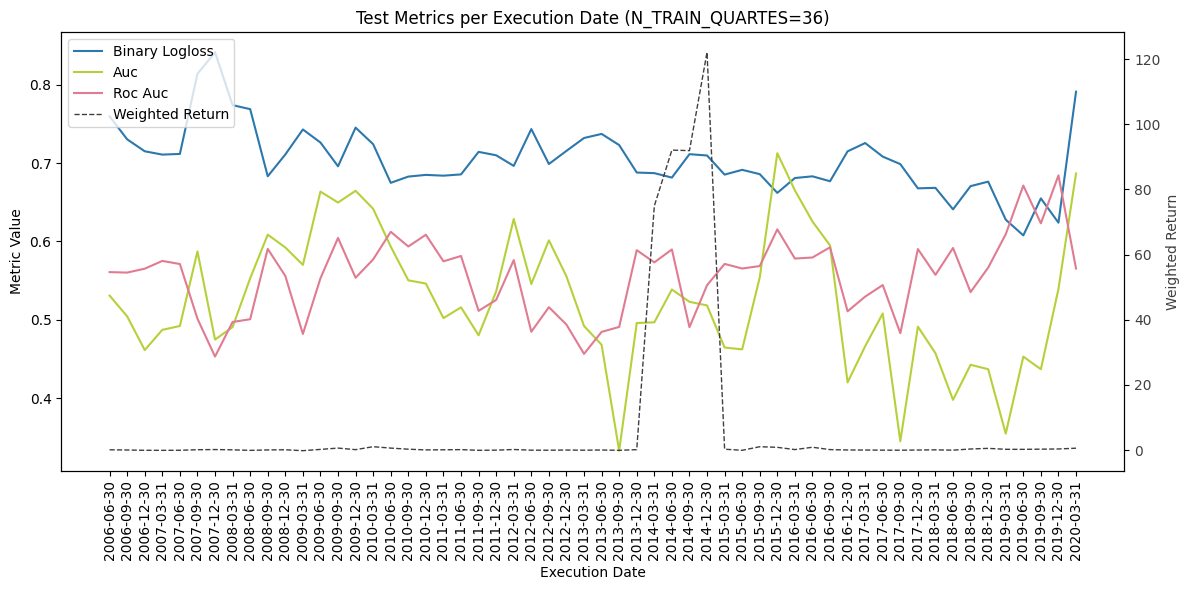

In [189]:
def plot_metrics_over_time(
    results_df,
    metrics=["binary_logloss", "auc", "roc_auc"],
    title="Metrics per Execution Date"
):
    plt.figure(figsize=(12, 6))
    color_map = {"binary_logloss": "#2c78ad","auc": "#b5d13a","roc_auc": "#e07b91","weighted-return": "#3f3f3f"}
    right_metric = "weighted-return" if "weighted-return" in metrics else None
    left_metrics = [m for m in metrics if m != right_metric]

    ax = plt.gca()
    for metric in left_metrics:
        ax.plot(
            results_df["execution_date"],
            results_df[metric],
            label=metric.replace("_", " ").title(),
            color=color_map.get(metric)
        )
    ax.set_xlabel("Execution Date")
    ax.set_ylabel("Metric Value")
    plt.xticks(rotation=90)

    if right_metric:
        ax2 = ax.twinx()
        ax2.plot(
            results_df["execution_date"],
            results_df[right_metric],
            label="Weighted Return",
            color=color_map[right_metric],
            linestyle="--",
            linewidth=1 
        )
        ax2.set_ylabel("Weighted Return", color=color_map[right_metric])
        ax2.tick_params(axis='y', labelcolor=color_map[right_metric])
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='upper left')
    else:
        ax.legend(loc='upper left')

    plt.title(title)
    plt.tight_layout()
    plt.show()
    
plot_metrics_over_time(
    train_results_final_tree,
    metrics=["binary_logloss", "auc", "roc_auc"],
    title=f"Train Metrics per Execution Date (N_TRAIN_QUARTES={N_TRAIN_QUARTES})"
)

plot_metrics_over_time(
    test_results_final_tree,
    metrics=["binary_logloss", "auc", "roc_auc", "weighted-return"],
    title=f"Test Metrics per Execution Date (N_TRAIN_QUARTES={N_TRAIN_QUARTES})"
)

**Hypothesis: Overlapping Training Windows Cause Artificially Smooth Training Metrics**

- In the training set, each model (per `execution_date`) shows metrics (logloss, AUC, ROC AUC) that form smooth, continuous lines across splits.
- This is unexpected: each model should be independent, with different data and market conditions, so metrics should appear scattered.
- The likely cause: the sliding window approach with high overlap.
    - `N_TRAIN_QUARTERS = 36` (9 years of data)
    - Execution dates are only 3 months apart
    - Result: consecutive models train on almost the same data, so their metrics are highly correlated.
- In contrast, validation metrics do not show this pattern, as each test set is truly independent.

**Conclusion:**  
The smoothness in training metrics is an artifact of overlapping training windows, not a sign of model generalization.


2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

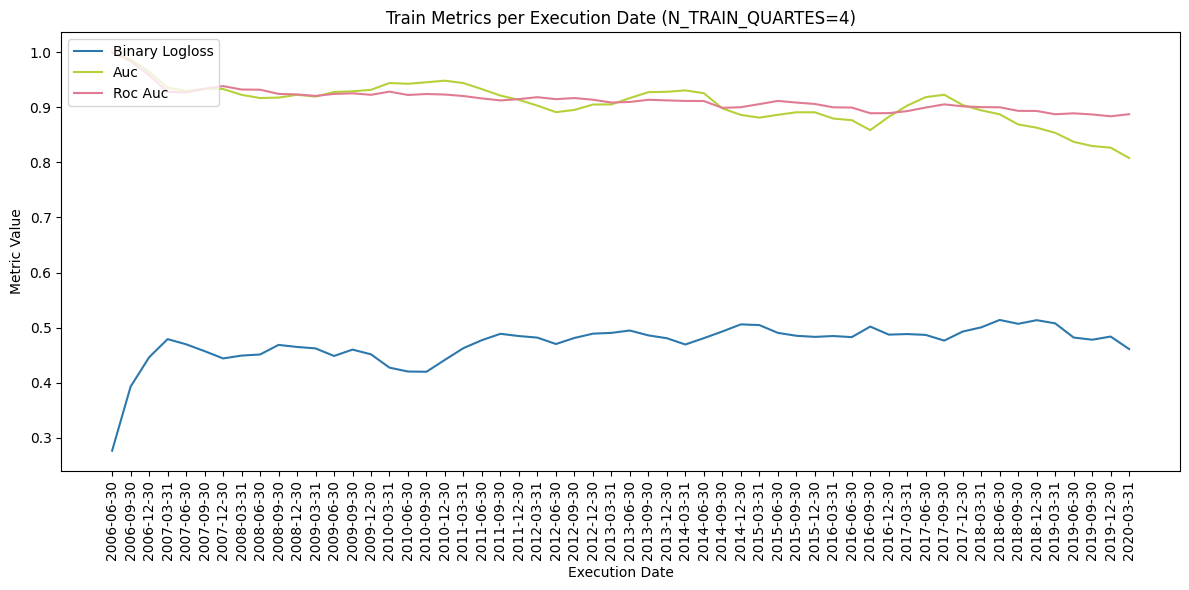

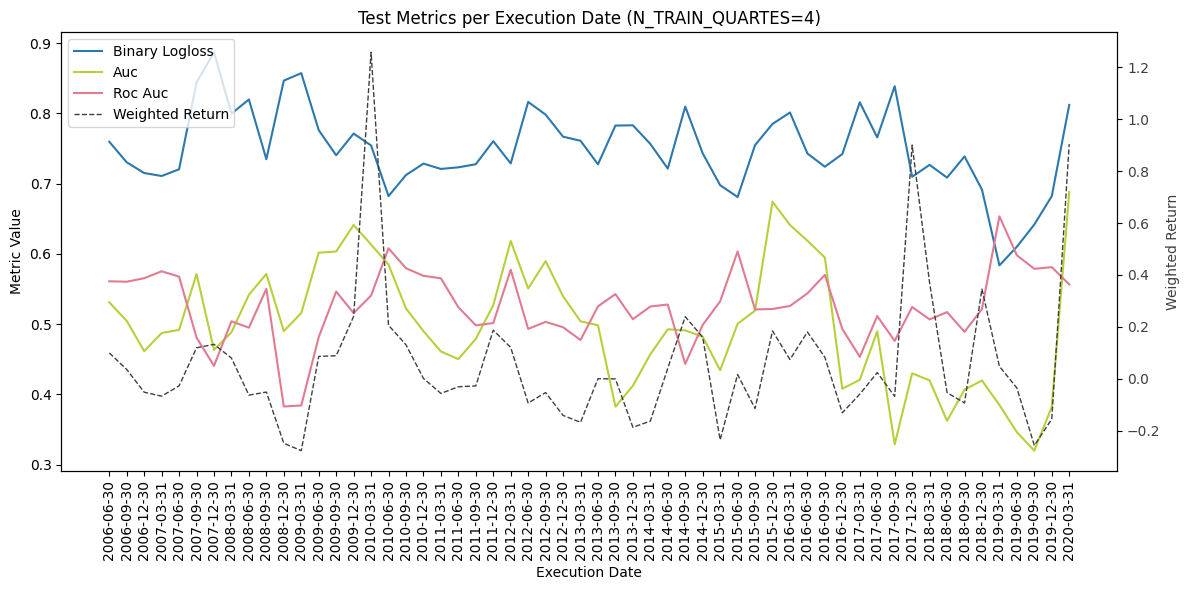

In [195]:
N_TRAIN_QUARTES = 4

all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    print(execution_date)
    (
        all_results, all_predicted_tickers_list, all_models, model, X_train, X_test
    ) = run_model_for_execution_date(
            execution_date, all_results, all_predicted_tickers_list, all_models, N_TREES, False
        )
    
all_predicted_tickers = pd.concat(all_predicted_tickers_list)

test_results = parse_results_into_df("valid_0", all_results)
train_results = parse_results_into_df("training", all_results)

test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")


plot_metrics_over_time(
    train_results_final_tree,
    metrics=["binary_logloss", "auc", "roc_auc"],
    title=f"Train Metrics per Execution Date (N_TRAIN_QUARTES={N_TRAIN_QUARTES})"
)

plot_metrics_over_time(
    test_results_final_tree,
    metrics=["binary_logloss", "auc", "roc_auc", "weighted-return"],
    title=f"Test Metrics per Execution Date (N_TRAIN_QUARTES={N_TRAIN_QUARTES})"
)

### **How to know if the model is working well?**

To properly assess whether our LightGBM model is adding real value, we need to compare it against simple baseline strategies.

1. **Market Cap Strategy**: Select the TOP_N tickers with the highest market capitalization at each execution date

2. **Random Strategy**: Randomly select TOP_N tickers at each execution date

3. **Momentum Strategy**: Select TOP_N tickers with the highest recent price performance

Procesing 1/64: 2005-06-30T00:00:00.000000000
Procesing 11/64: 2007-12-30T00:00:00.000000000
Procesing 21/64: 2010-06-30T00:00:00.000000000
Procesing 31/64: 2012-12-30T00:00:00.000000000
Procesing 41/64: 2015-06-30T00:00:00.000000000
Procesing 51/64: 2017-12-30T00:00:00.000000000
Procesing 61/64: 2020-06-30T00:00:00.000000000
⚠️  Only 0 tickers available for execution date 2020-06-30T00:00:00.000000000. Need at least 10.
⚠️  Only 0 tickers available for execution date 2020-09-30T00:00:00.000000000. Need at least 10.
⚠️  Only 0 tickers available for execution date 2020-12-30T00:00:00.000000000. Need at least 10.
⚠️  Only 0 tickers available for execution date 2021-03-27T00:00:00.000000000. Need at least 10.
ML Model    :  0.0613 (σ=0.2742, Sharpe=0.22, Win=51.8%)
Market Cap  :  0.0181 (σ=0.0920, Sharpe=0.20, Win=57.1%)
Random      :  0.0853 (σ=0.2136, Sharpe=0.40, Win=57.1%)
Momentum    :  1.4516 (σ=4.9388, Sharpe=0.29, Win=60.7%)
LGB vs Market Cap:  27/56 (48.2%)
LGB vs Random:      27

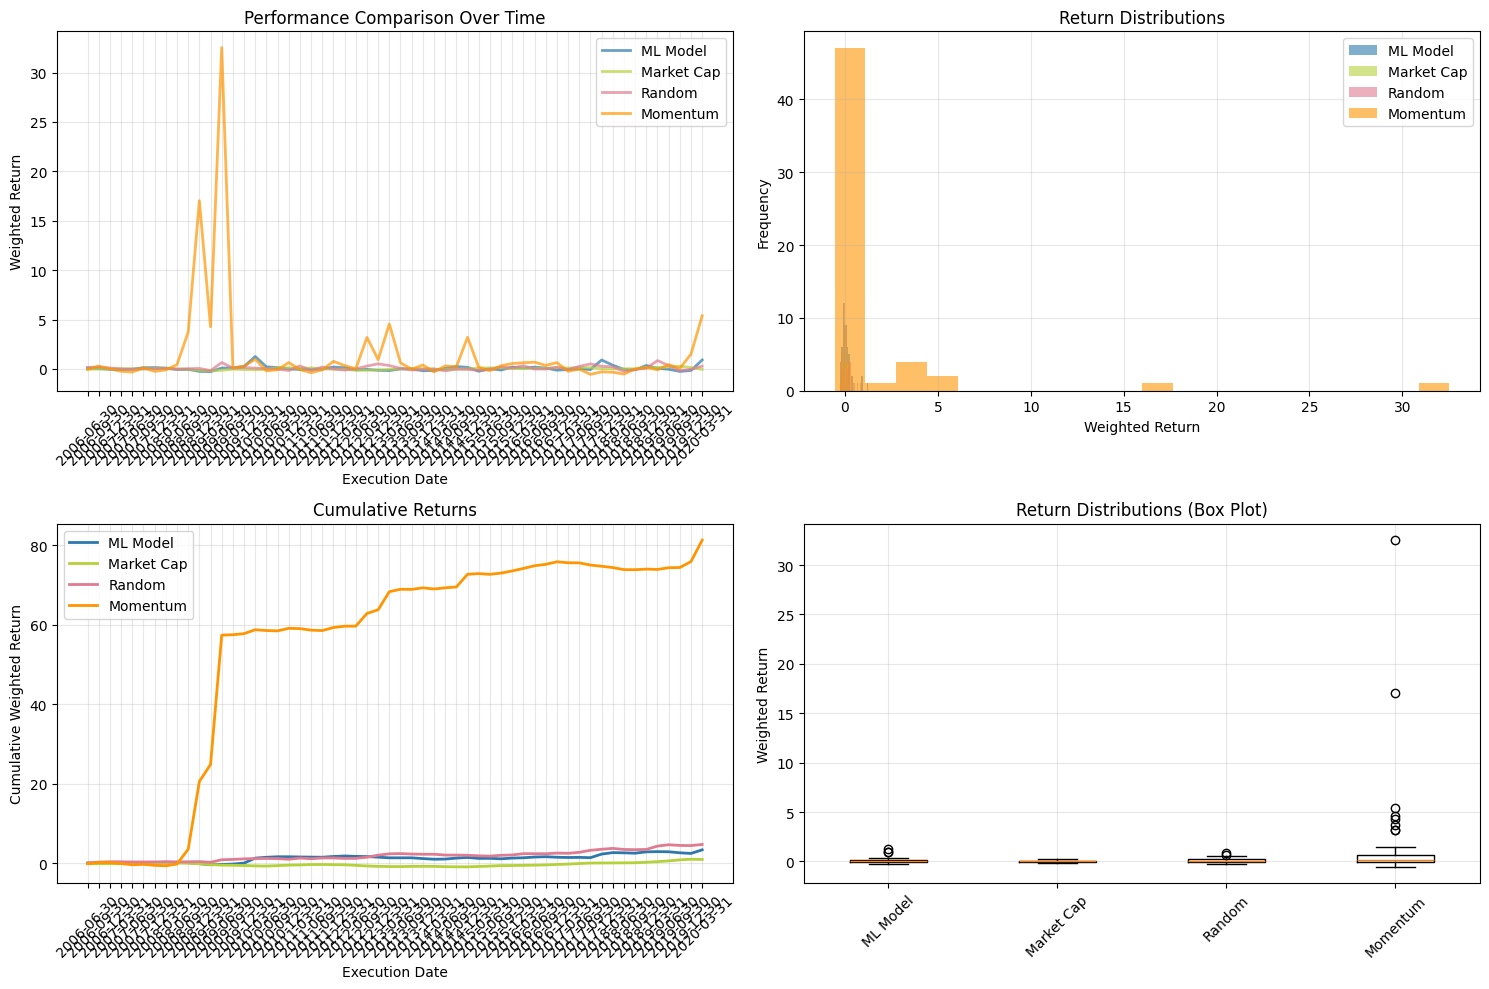

In [203]:
def market_cap_strategy(test_set, top_n=10):
    market_cap_col = 'Market_cap'
    return test_set.nlargest(top_n, market_cap_col)

def random_strategy(test_set, top_n=10, random_state=None):
    if random_state is None:
        raise ValueError("random_state must be provided for reproducibility")
    
    selected = test_set.sample(min(top_n, len(test_set)), random_state=random_state)
    return selected

def momentum_strategy(test_set, top_n=10):
    momentum_col = 'stock_change__minus_120'
    return test_set.nlargest(top_n, momentum_col)

def run_benchmark_strategies(execution_date, top_n=10):
    _, test_set = split_train_test_by_period(data_set, execution_date)
    
    if len(test_set) < top_n:
        print(f"⚠️  Only {len(test_set)} tickers available for execution date {execution_date}. Need at least {top_n}.")
        return None
    
    results = {
        'execution_date': execution_date,
        'total_tickers': len(test_set)
    }
    
    # 1. Market Cap Strategy
    try:
        market_cap_selection = market_cap_strategy(test_set, top_n)
        market_cap_return = market_cap_selection['diff_ch_sp500'].mean()
        results['market_cap_return'] = market_cap_return
        results['market_cap_tickers'] = list(market_cap_selection['Ticker'].values)
    except Exception as e:
        print(f"Error en Market Cap strategy: {e}")
        results['market_cap_return'] = np.nan
        results['market_cap_tickers'] = []
    
    # 2. Random Strategy
    try:
        random_selection = random_strategy(test_set, top_n, random_state=1)
        random_return = random_selection['diff_ch_sp500'].mean()
        results['random_return'] = random_return
        results['random_tickers'] = list(random_selection['Ticker'].values)
    except Exception as e:
        print(f"Error en Random strategy: {e}")
        results['random_return'] = np.nan
        results['random_tickers'] = []
    
    # 3. Momentum Strategy
    try:
        momentum_selection = momentum_strategy(test_set, top_n)
        momentum_return = momentum_selection['diff_ch_sp500'].mean()
        results['momentum_return'] = momentum_return
        results['momentum_tickers'] = list(momentum_selection['Ticker'].values)
    except Exception as e:
        print(f"Error en Momentum strategy: {e}")
        results['momentum_return'] = np.nan
        results['momentum_tickers'] = []
    
    return results

def run_all_benchmarks():
    benchmark_results = []
    
    for i, execution_date in enumerate(execution_dates):
        if i % 10 == 0:  # Progress indicator
            print(f"Procesing {i+1}/{len(execution_dates)}: {execution_date}")
        
        result = run_benchmark_strategies(execution_date, top_n=TOP_N)
        if result is not None:
            benchmark_results.append(result)
    
    benchmark_df = pd.DataFrame(benchmark_results)
    return benchmark_df

def compare_strategies_with_model(benchmark_df, test_results_final_tree):
    model_results = test_results_final_tree[['execution_date', 'weighted-return']].copy()
    model_results.columns = ['execution_date', 'model_return']
    
    benchmark_df['execution_date'] = benchmark_df['execution_date'].astype(str)
    model_results['execution_date'] = model_results['execution_date'].astype(str)
    
    comparison_df = pd.merge(benchmark_df, model_results, on='execution_date', how='inner')
    
    strategies = ['model_return', 'market_cap_return', 'random_return', 'momentum_return']
    strategy_names = ['ML Model', 'Market Cap', 'Random', 'Momentum']
    
    for strategy, name in zip(strategies, strategy_names):
        if strategy in comparison_df.columns:
            mean_return = comparison_df[strategy].mean()
            std_return = comparison_df[strategy].std()
            sharpe = mean_return / std_return if std_return > 0 else 0
            win_rate = (comparison_df[strategy] > 0).mean() * 100
            
            print(f"{name:12}: {mean_return:7.4f} (σ={std_return:.4f}, Sharpe={sharpe:.2f}, Win={win_rate:.1f}%)")
    
    model_vs_market_cap = (comparison_df['model_return'] > comparison_df['market_cap_return']).sum()
    model_vs_random = (comparison_df['model_return'] > comparison_df['random_return']).sum()
    model_vs_momentum = (comparison_df['model_return'] > comparison_df['momentum_return']).sum()
    total_periods = len(comparison_df)
    
    print(f"LGB vs Market Cap:  {model_vs_market_cap}/{total_periods} ({model_vs_market_cap/total_periods*100:.1f}%)")
    print(f"LGB vs Random:      {model_vs_random}/{total_periods} ({model_vs_random/total_periods*100:.1f}%)")
    print(f"LGB vs Momentum:    {model_vs_momentum}/{total_periods} ({model_vs_momentum/total_periods*100:.1f}%)")
    
    return comparison_df

def plot_benchmark_comparison(comparison_df):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    strategies = ['model_return', 'market_cap_return', 'random_return', 'momentum_return']
    colors = ['#2c78ad', '#b5d13a', '#e07b91', '#ff9500']
    labels = ['ML Model', 'Market Cap', 'Random', 'Momentum']
    
    for strategy, color, label in zip(strategies, colors, labels):
        if strategy in comparison_df.columns:
            plt.plot(comparison_df['execution_date'], comparison_df[strategy], 
                    color=color, label=label, alpha=0.7, linewidth=2)
    
    plt.title('Performance Comparison Over Time')
    plt.xlabel('Execution Date')
    plt.ylabel('Weighted Return')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    for strategy, color, label in zip(strategies, colors, labels):
        if strategy in comparison_df.columns:
            plt.hist(comparison_df[strategy], alpha=0.6, label=label, color=color, bins=20)
    
    plt.title('Return Distributions')
    plt.xlabel('Weighted Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    for strategy, color, label in zip(strategies, colors, labels):
        if strategy in comparison_df.columns:
            cumulative = comparison_df[strategy].cumsum()
            plt.plot(comparison_df['execution_date'], cumulative, 
                    color=color, label=label, linewidth=2)
    
    plt.title('Cumulative Returns')
    plt.xlabel('Execution Date')
    plt.ylabel('Cumulative Weighted Return')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    data_for_box = []
    labels_for_box = []
    
    for strategy, label in zip(strategies, labels):
        if strategy in comparison_df.columns:
            data_for_box.append(comparison_df[strategy].dropna())
            labels_for_box.append(label)
    
    plt.boxplot(data_for_box, labels=labels_for_box)
    plt.title('Return Distributions (Box Plot)')
    plt.ylabel('Weighted Return')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def full_benchmark_analysis():
    benchmark_df = run_all_benchmarks()
    comparison_df = compare_strategies_with_model(benchmark_df, test_results_final_tree)
    plot_benchmark_comparison(comparison_df)
    
    return comparison_df

comparison_results = full_benchmark_analysis()

Our system does not seem to outperform the random baseline, which is a very bad sign and means it is not adding value. Furthermore, the momentum system appears to work very well.

In [ ]:
def plot_training_curve(
    date: str,
    results: dict,
    metrics: list = ["weighted-return", "binary_logloss"],
    set_names: tuple = ("training", "valid_0"),
    labels: dict = None,
    colors: list = None
):
    if labels is None:
        labels = {
            "weighted-return": "Weighted Return",
            "binary_logloss": "Binary Log-loss",
            "auc": "AUC",
            "roc_auc": "ROC AUC"
        }
    if colors is None:
        colors = [
            "#2c78ad",  # color para metrica 1
            "#b5d13a",  # color para metrica 2
        ]

    n = len(metrics)
    for i in range(0, n, 2):
        metrics_pair = metrics[i:i+2]
        fig, ax1 = plt.subplots(figsize=(10, 6))
        iters = np.arange(1, len(results[date][set_names[0]][metrics_pair[0]]) + 1)

        # Si weighted-return está en las métricas, usar doble eje
        use_dual_axis = "weighted-return" in metrics_pair and len(metrics_pair) > 1

        if use_dual_axis:
            # Primer métrica (eje izquierdo)
            for idx, set_name in enumerate(set_names):
                ax1.plot(
                    iters,
                    results[date][set_name][metrics_pair[0]],
                    label=f"{labels.get(metrics_pair[0], metrics_pair[0])} ({set_name})",
                    color=colors[0],
                    linestyle="-" if set_name == set_names[0] else "--"
                )
            ax1.set_ylabel(labels.get(metrics_pair[0], metrics_pair[0]), color=colors[0])
            ax1.tick_params(axis='y', labelcolor=colors[0])
            lines, labels_ = ax1.get_legend_handles_labels()

            # Segunda métrica (eje derecho)
            ax2 = ax1.twinx()
            for idx, set_name in enumerate(set_names):
                ax2.plot(
                    iters,
                    results[date][set_name][metrics_pair[1]],
                    label=f"{labels.get(metrics_pair[1], metrics_pair[1])} ({set_name})",
                    color=colors[1],
                    linestyle="-" if set_name == set_names[0] else "--"
                )
            ax2.set_ylabel(labels.get(metrics_pair[1], metrics_pair[1]), color=colors[1])
            ax2.tick_params(axis='y', labelcolor=colors[1])
            lines2, labels2 = ax2.get_legend_handles_labels()
            lines += lines2
            labels_ += labels2
        else:
            # Ambas métricas en el mismo eje
            for m_idx, metric in enumerate(metrics_pair):
                for idx, set_name in enumerate(set_names):
                    ax1.plot(
                        iters,
                        results[date][set_name][metric],
                        label=f"{labels.get(metric, metric)} ({set_name})",
                        color=colors[m_idx],
                        linestyle="-" if set_name == set_names[0] else "--"
                    )
            ax1.set_ylabel(" / ".join([labels.get(m, m) for m in metrics_pair]))
            lines, labels_ = ax1.get_legend_handles_labels()

        ax1.set_xlabel("Number of trees")
        ax1.legend(lines, labels_, loc='upper left')
        plt.title(f"Training/Validation curves for {date} ({', '.join(metrics_pair)})")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### Optimizing Training Time

In [58]:
N_TRAIN_QUARTES = 8   # Get only the last 8 quarters (2 years)

In [74]:
def get_fast_training_params():
    return {
        "random_state": 1,
        "verbosity": -1,
        "n_jobs": 10, 
        "n_estimators": 10,  
        "max_depth": 10,     
        "num_leaves": 31,   
        "learning_rate": 0.1,
        "feature_fraction": 0.8,  # Use 80% of features for each iteration
        "bagging_fraction": 0.8,  # Use 80% of data for each iteration
        "bagging_freq": 5,
        "objective": "binary",
        "metric": "binary_logloss"
    }

def train_model_fast(train_set, test_set):
    columns_to_remove = get_columns_to_remove()
    X_train = train_set.drop(columns=columns_to_remove, errors="ignore")
    X_test = test_set.drop(columns=columns_to_remove, errors="ignore")
    y_train = train_set["target"]
    y_test = test_set["target"]
    
    params = get_fast_training_params()
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    model = lgb.train(
        params=params,
        train_set=lgb_train,
        valid_sets=[lgb_test, lgb_train],
        feval=[top_wt_performance, pr_auc_metric, roc_auc_metric],
        callbacks=[
            lgb.record_evaluation(eval_result=eval_result),
            lgb.early_stopping(10)
        ] 
    )
    return model, eval_result, X_train, X_test

def run_fast_model_for_execution_date(
            execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,
            include_nulls_in_test = False
        ):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None
        
        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model_fast(
                 train_set,test_set
            )
            test_set['prob'] = model.predict(X_test)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)
        return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test

all_fast_results = {}
all_fast_predicted_tickers_list = []
all_fast_models = {}

# Get the last 70% of execution dates
recent_execution_dates = execution_dates[int(len(execution_dates) * 0.7):]

for execution_date in recent_execution_dates:
    print(execution_date)
    all_fast_results,all_fast_predicted_tickers_list,all_fast_models,model,X_train,X_test = run_fast_model_for_execution_date(
         execution_date,all_fast_results,all_fast_predicted_tickers_list,all_fast_models,False
        )
all_fast_predicted_tickers = pd.concat(all_fast_predicted_tickers_list)

2016-06-30T00:00:00.000000000
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[4]	training's binary_logloss: 0.653552	training's weighted-return: 0.250395	training's auc: 0.66341	training's roc_auc: 0.712823	valid_0's binary_logloss: 0.715383	valid_0's weighted-return: 0.277114	valid_0's auc: 0.637695	valid_0's roc_auc: 0.557691
2016-09-30T00:00:00.000000000
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[4]	training's binary_logloss: 0.65962	training's weighted-return: 0.31298	training's auc: 0.673712	training's roc_auc: 0.708655	valid_0's binary_logloss: 0.698311	valid_0's weighted-return: -0.0535114	valid_0's auc: 0.577154	valid_0's roc_auc: 0.56647
2016-12-30T00:00:00.000000000
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1]	training's binary_logloss: 0.683138	training's weighted-return: 0.0556464

In [75]:
test_fast_results = parse_results_into_df("valid_0", results=all_fast_results)
train_fast_results = parse_results_into_df("training", results=all_fast_results)

test_fast_results_final_tree = test_fast_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_fast_results_final_tree = train_fast_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

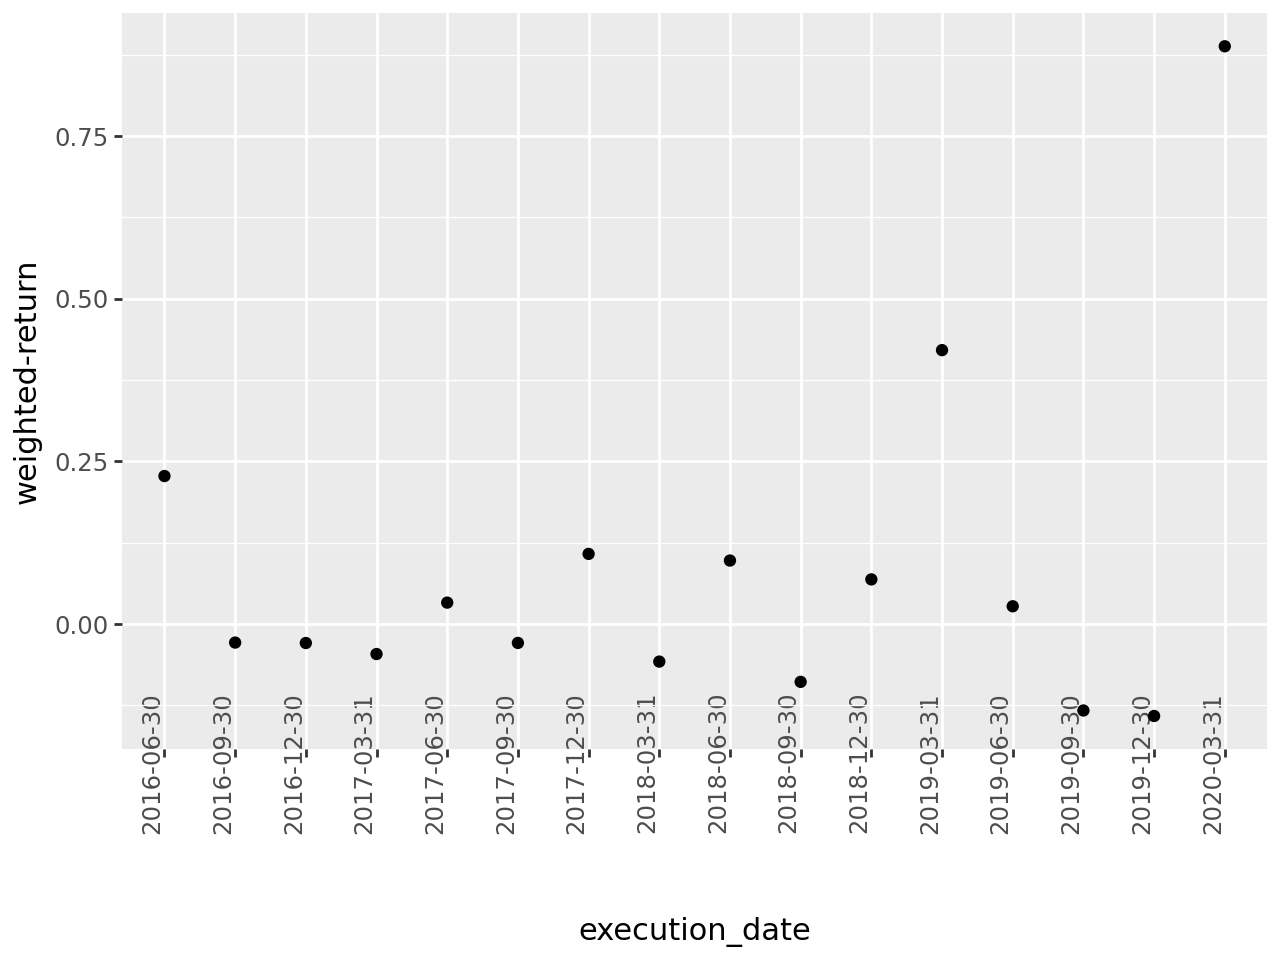

In [76]:
ggplot(test_fast_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

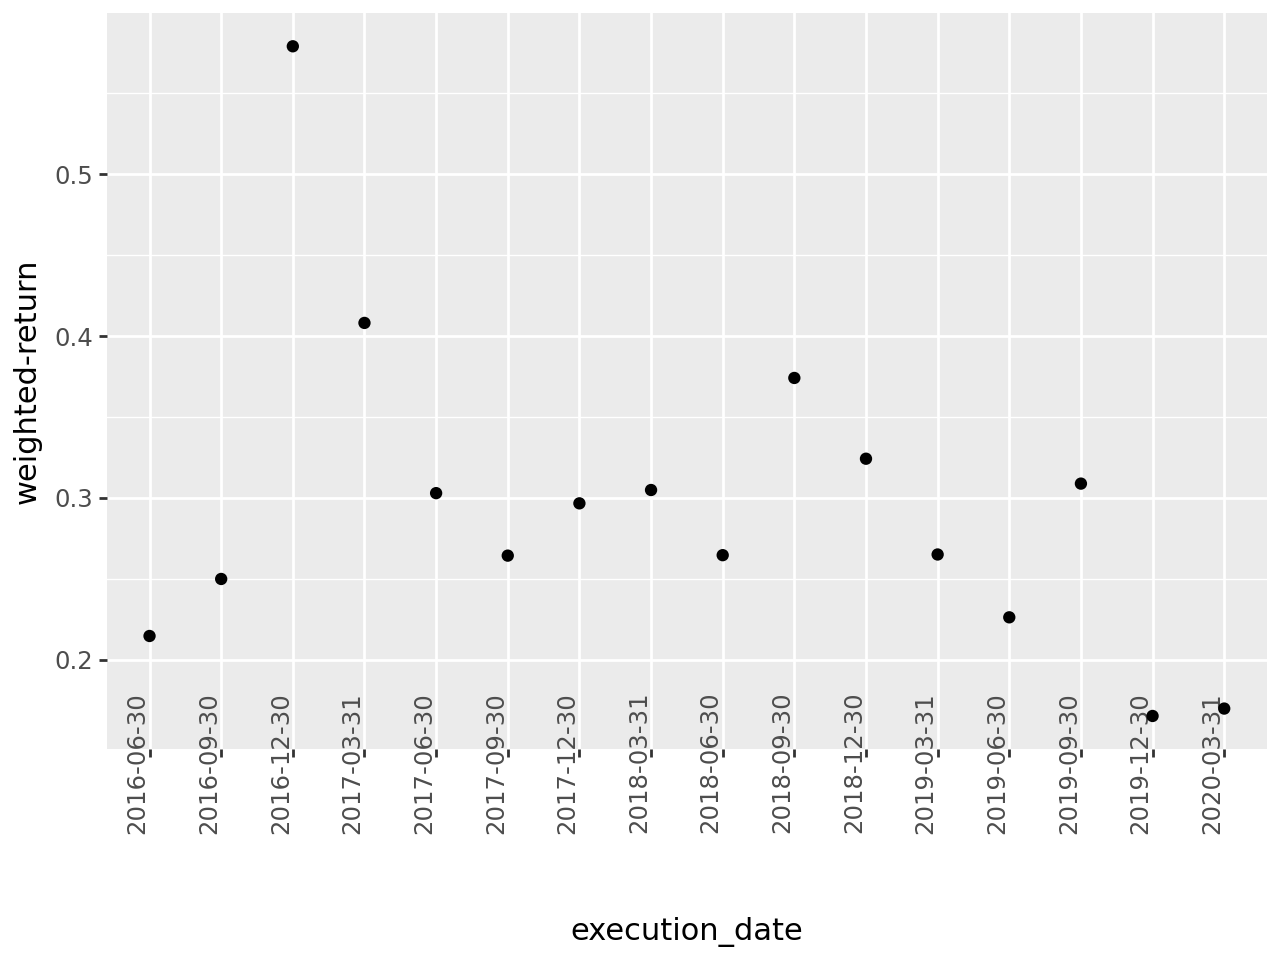

In [77]:
ggplot(train_fast_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

Lets see the training curves:

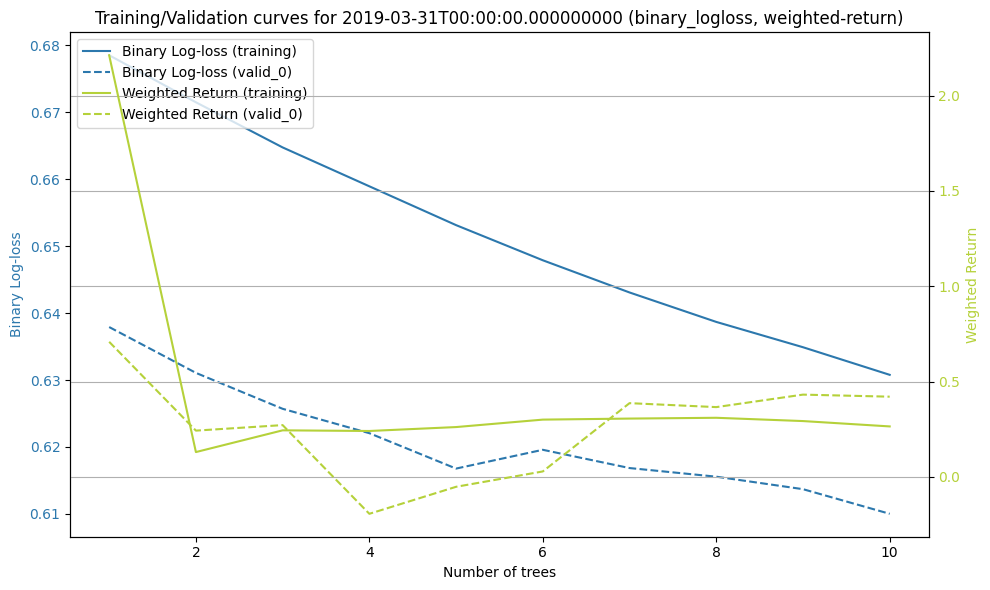

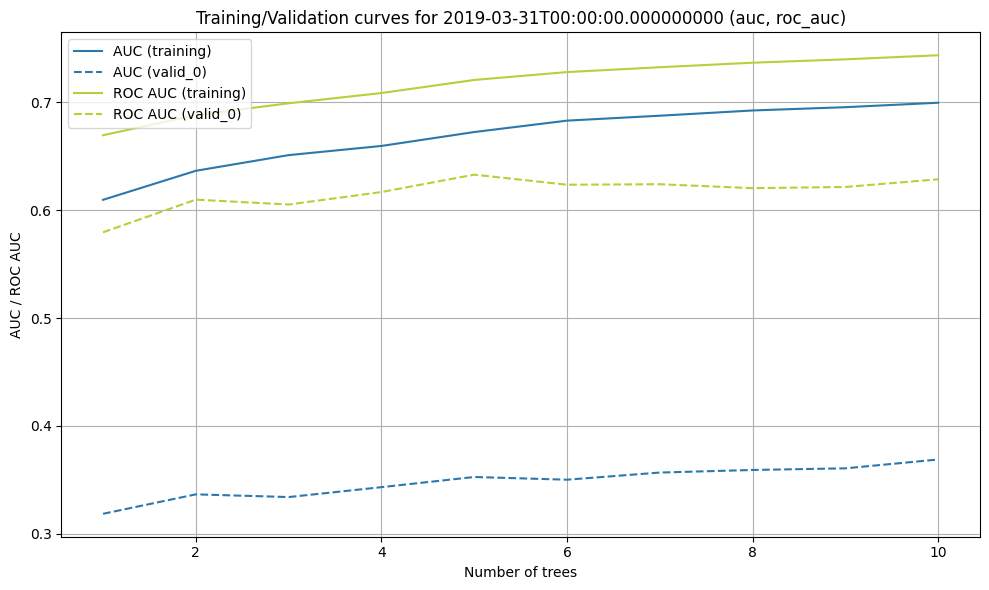

In [78]:
date = np.datetime64('2019-03-31T00:00:00.000000000')

plot_training_curve(date, all_fast_results, ['binary_logloss', 'weighted-return', 'auc', 'roc_auc'])

1. We can see 2 outliers in validation predicts, lets see the result without the outlier, to zoom in the remaining predictions

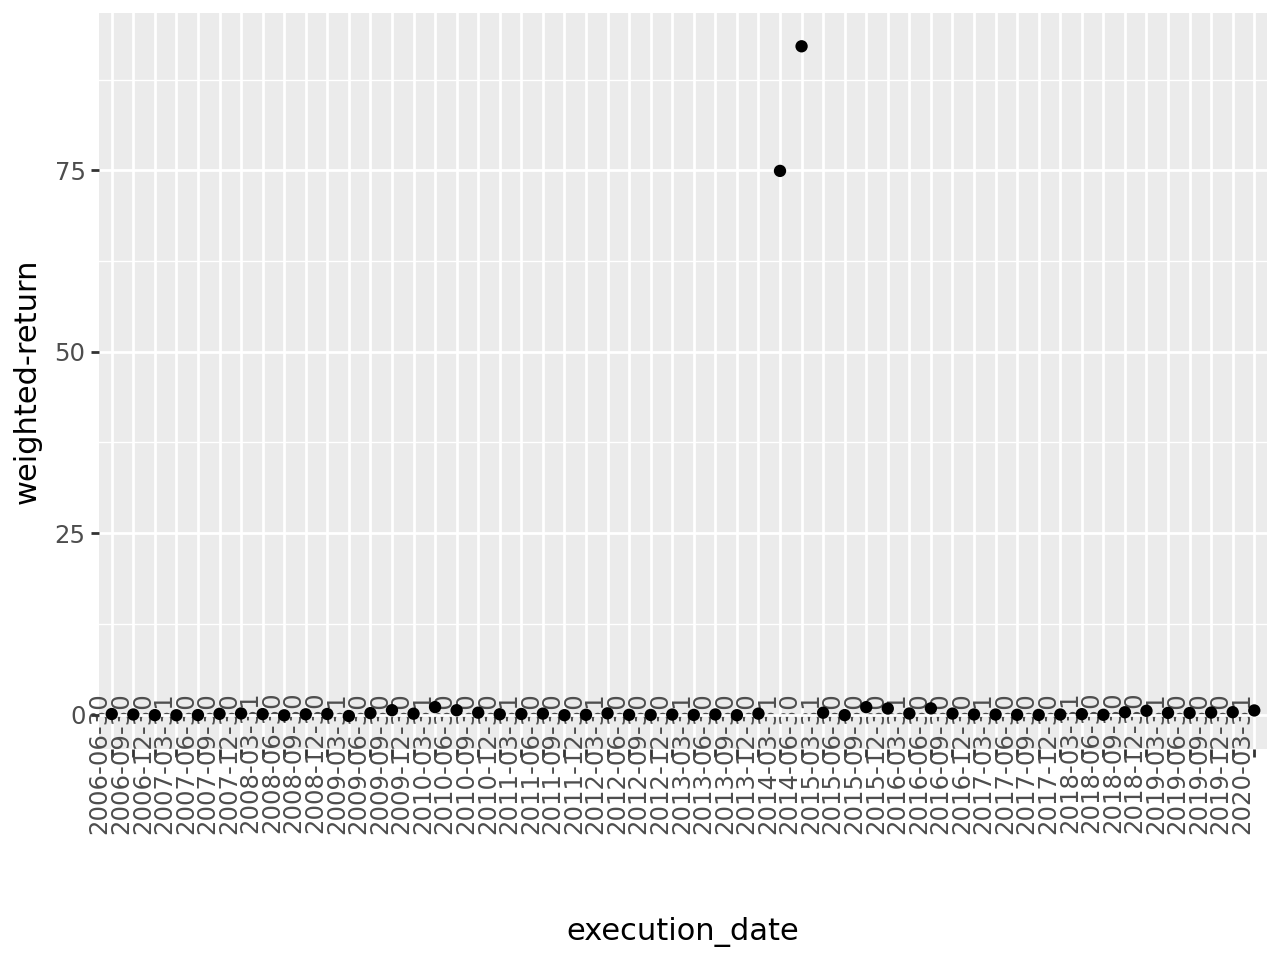

In [21]:
test_results_final_tree_without_outliers = test_results_final_tree[
    ~test_results_final_tree["execution_date"].isin(["2014-09-30", "2014-12-30"])
]

ggplot(test_results_final_tree_without_outliers) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

Most of theme are above 0.0 and under 1.00. Having 12 execution_date with negative return

Why those 2 outliers?

---------------------------------------------------------------------------------------------------

Lets see which are the most important features:

In [23]:
def get_top_n_features_across_models(n: int = 15, models=all_models) -> list:
    feature_importance_total = {}
    for model in models.values():
        fi = model.feature_importance()
        fn = model.feature_name()
        for i in range(len(fn)):
            feature_importance_total[fn[i]] = feature_importance_total.get(fn[i], 0) + fi[i]
    if not feature_importance_total:
        print("No feature importances found. Are the models trained?")
        return []
    fi_df = pd.DataFrame([
        {"feature": k, "total_importance": v}
        for k, v in feature_importance_total.items()
    ])
    fi_df = fi_df.sort_values("total_importance", ascending=False)
    return fi_df["feature"].head(n).tolist()

In [24]:
def plot_corr(
    df: pd.DataFrame, columns: list[str], figsize: tuple = (8, 6)
    ) -> None:

    threshold = 15 

    if not all(col in df.columns for col in columns):
        missing = [col for col in columns if col not in df.columns]
        raise ValueError(f"Columns not found in dataframe: {missing}")

    corr = df[columns].corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))
    corr_masked = corr.mask(mask)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(corr_masked, vmin=-1, vmax=1, cmap="coolwarm")

    ax.set_xticks(np.arange(len(columns)))
    ax.set_yticks(np.arange(len(columns)))
    ax.set_xticklabels(columns, rotation=90)
    ax.set_yticklabels(columns)

    # Show correlation values if number of columns is below threshold
    if len(columns) <= threshold:
        for i in range(len(columns)):
            for j in range(len(columns)):
                if not mask[i, j]:
                    val = corr.iloc[i, j]
                    if not np.isnan(val):
                        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="black", fontsize=9)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Pearson $r$", rotation=270, labelpad=15)

    ax.set_title("Correlation matrix (lower triangle)")
    plt.tight_layout()
    plt.show()

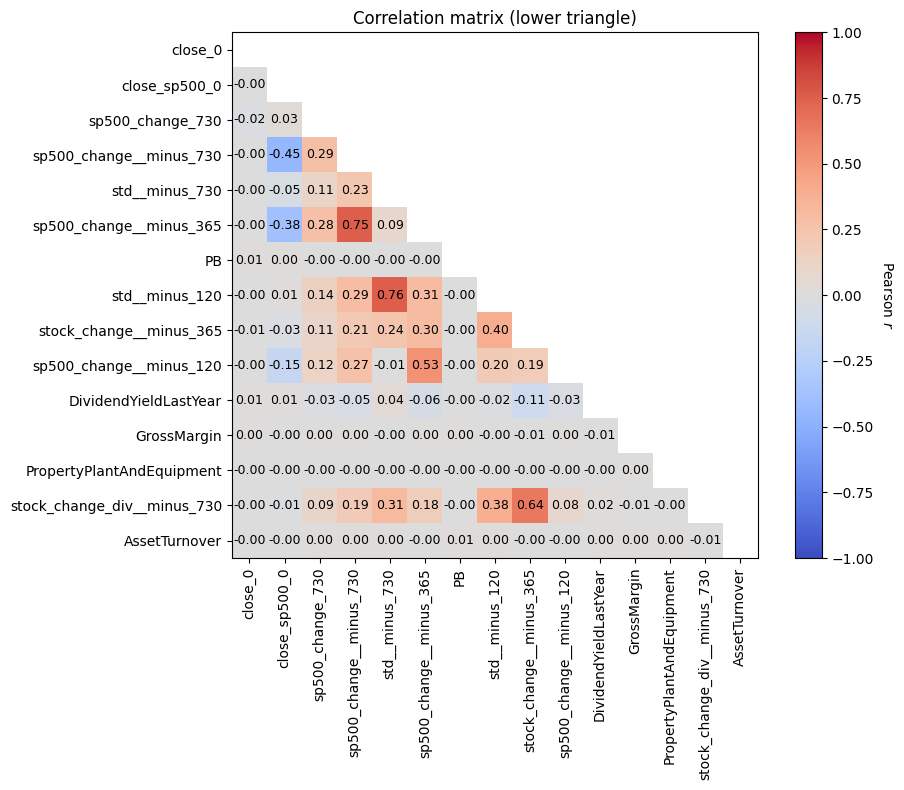

In [155]:
plot_corr(
    data_set,
    columns=get_top_n_features_across_models(15),
    figsize=(10, 8)
)

We can see highly correlated features groups:

* **SP500:** `sp500_change__minus_730`, `sp500_change__minus_365` and `sp500_change__minus_120`
* **Volatility:** `std__minus_730`, `std__minus_730` and `std__minus_120`
* **Stock Change:** `stock_change__minus_120` vs. `stock_change_div__minus_730`

In general, those features with the change in short time vs the change in long time

### PCA

I'll compress each block into 1–2 orthogonal “factors”.

- PC-1 of the three S&P-500 change variables
- PC-1 of the three std_* variables
- ...

In [156]:
data_set[data_set['diff_ch_sp500'].isna()]

,Ticker,date,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,...,Revenue_change_2_years,NetCashFlow_change_1_years,NetCashFlow_change_2_years,CurrentRatio_change_1_years,CurrentRatio_change_2_years,Market_cap__minus_365,Market_cap__minus_730,diff_ch_sp500,count,target
2273,MBCN,2005-06-30,0.0102,3.9834,-7.5984,0.9526,7.0169,-0.0199,0.2390,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1992,NaN
21460,EMCF,2007-09-30,0.0108,1.7110,-2.0470,0.5730,9.0150,0.0000,-0.0190,-0.0370,...,0.145303,-0.251442,0.870112,NaN,NaN,37.089000,33.72880,NaN,2176,NaN
22291,FPAY,2007-09-30,0.0216,0.0311,-0.0542,-0.4688,4.2600,0.0399,-0.3213,-0.0237,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2176,NaN
22634,CNET,2007-09-30,0.1012,0.0380,0.0000,-0.0248,0.0455,0.0062,0.0000,0.0015,...,NaN,303.666667,NaN,NaN,NaN,NaN,NaN,NaN,2176,NaN
23146,HBP,2007-12-31,0.8458,-21.0000,0.6000,10.2000,1.8000,-20.5000,27.9000,-2.7000,...,-0.202698,-1.914894,-7.600000,-0.010850,0.251385,122.633500,185.42727,NaN,2199,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170478,SMSI,2020-12-31,0.1703,0.0100,0.2240,-0.3520,25.7540,0.0000,-2.4280,0.1530,...,0.951683,-1.156062,-1.252562,-0.328138,-0.209308,155.732110,67.41244,NaN,3245,NaN
170479,COOP,2020-12-31,NaN,1277.0000,38.0000,-1878.0000,NaN,-4555.0000,-228.0000,3766.0000,...,0.526816,-1.000000,1.000000,NaN,NaN,675.415520,873.30330,NaN,3245,NaN
170480,AC,2020-12-31,0.0081,-3.2620,2.7200,-7.2800,39.5090,-0.6540,-13.8040,16.0620,...,-0.166645,-3.960837,-3.597568,0.044353,-0.599536,685.504833,918.31667,NaN,3245,NaN
170481,CRON,2020-12-31,0.0089,-1.2760,-17.6610,-37.7730,1289.7890,0.0000,-4.7240,23.8230,...,2.854353,-1.103481,-8.328635,0.403737,4.525737,1943.744040,3205.92609,NaN,3245,NaN


In [157]:
sp500_cols = [
    "sp500_change__minus_730",
    "sp500_change__minus_365",
    "sp500_change__minus_120",
]

vol_cols = [
    "std__minus_730",
    "std__minus_365",
    "std__minus_120",
]

stock_change_cols = [
    "stock_change__minus_120",
    "stock_change__minus_365",
    "stock_change__minus_730",
]

stock_change_div_cols = [
    "stock_change_div__minus_120",
    "stock_change_div__minus_365",
    "stock_change_div__minus_730",
]

# build per-group PCA pipelines -----------------------------
pipelines = {
    "sp500_trend_pc": Pipeline([
        ("scale", StandardScaler()),
        ("pca", PCA(n_components=1))
    ]),
    "volatility_pc": Pipeline([
        ("impute", SimpleImputer(strategy="mean")),
        ("scale", StandardScaler()),
        ("pca", PCA(n_components=1))
    ]),
    "stock_change_trend_pc": Pipeline([
        ("impute", SimpleImputer(strategy="mean")),
        ("scale", StandardScaler()),
        ("pca", PCA(n_components=1))
    ]),
    "stock_change_div_trend_pc": Pipeline([
        ("impute", SimpleImputer(strategy="mean")),
        ("scale", StandardScaler()),
        ("pca", PCA(n_components=1))
    ]),
}

def add_pcs(df, fit=True):
    df_new = df.copy()
    for name, pipe in pipelines.items():
        if 'sp500' in name:
            cols = sp500_cols
        elif 'volatility' in name:
            cols = vol_cols
        elif 'stock_change_div' in name:
            cols = stock_change_div_cols
        elif 'stock_change' in name:
            cols = stock_change_cols
        else:
            raise ValueError(f"Unknown pipeline name: {name}")
        if fit:
            pipe.fit(df_new[cols])
        df_new[name] = pipe.transform(df_new[cols])[:, 0]
        df_new = df_new.drop(columns=cols)            # drop raw cols
    return df_new

Use pca in walk-forward loop:

In [ ]:
all_results_pca = {}
all_predicted_tickers_list_pca = []
all_models_pca = {}

for execution_date in execution_dates:
    print(execution_date)
    (
        all_results_pca,all_predicted_tickers_list_pca,all_models_pca,model,
        X_train,X_test
    ) = run_model_for_execution_date(
        execution_date,all_results_pca,all_predicted_tickers_list_pca,
        all_models_pca,N_TREES,False, pca=True)
    
all_predicted_tickers_pca = pd.concat(all_predicted_tickers_list_pca) 

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [165]:
for name, pipe in pipelines.items():
     evr = pipe.named_steps['pca'].explained_variance_ratio_[0]
     print(f"{name}: {evr:.2%} of variance" )

sp500_trend_pc: 70.31% of variance
volatility_pc: 91.68% of variance
stock_change_trend_pc: 66.45% of variance
stock_change_div_trend_pc: 66.42% of variance


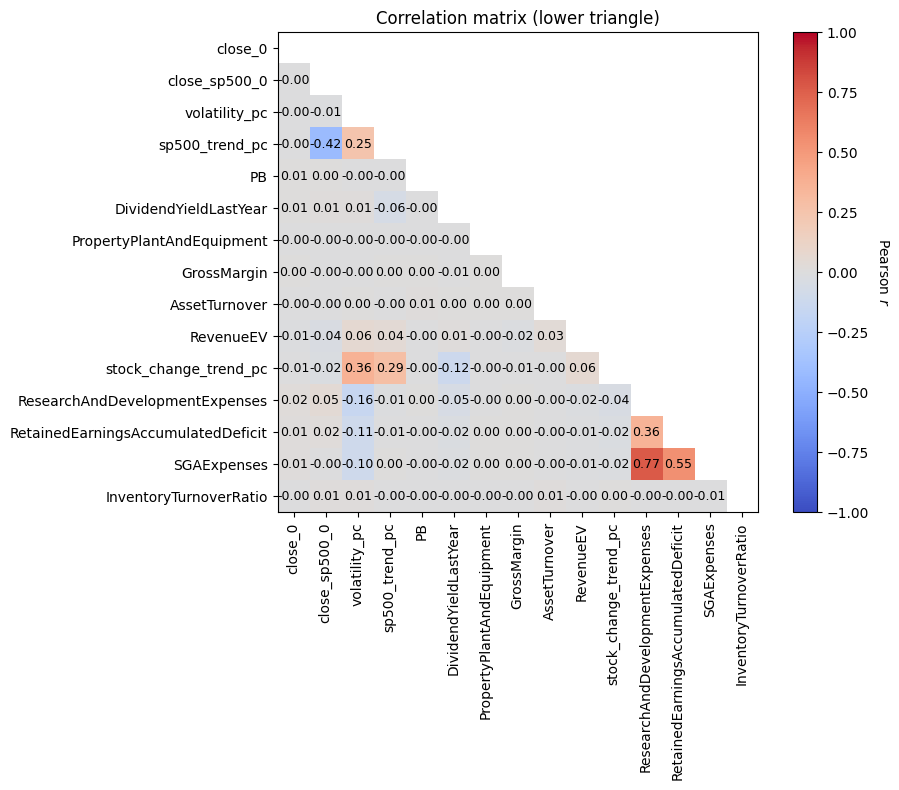

In [166]:
plot_corr(
    add_pcs(data_set, fit=False),
    columns=get_top_n_features_across_models(15, all_models_pca),
    figsize=(10, 8)
)

This PCA components capture mostly all the variance between same family features

In [167]:
test_results_pca = parse_results_into_df("valid_0", results=all_results_pca)
train_results_pca = parse_results_into_df("training", results=all_results_pca)
test_results_final_tree_pca = test_results_pca.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree_pca = train_results_pca.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

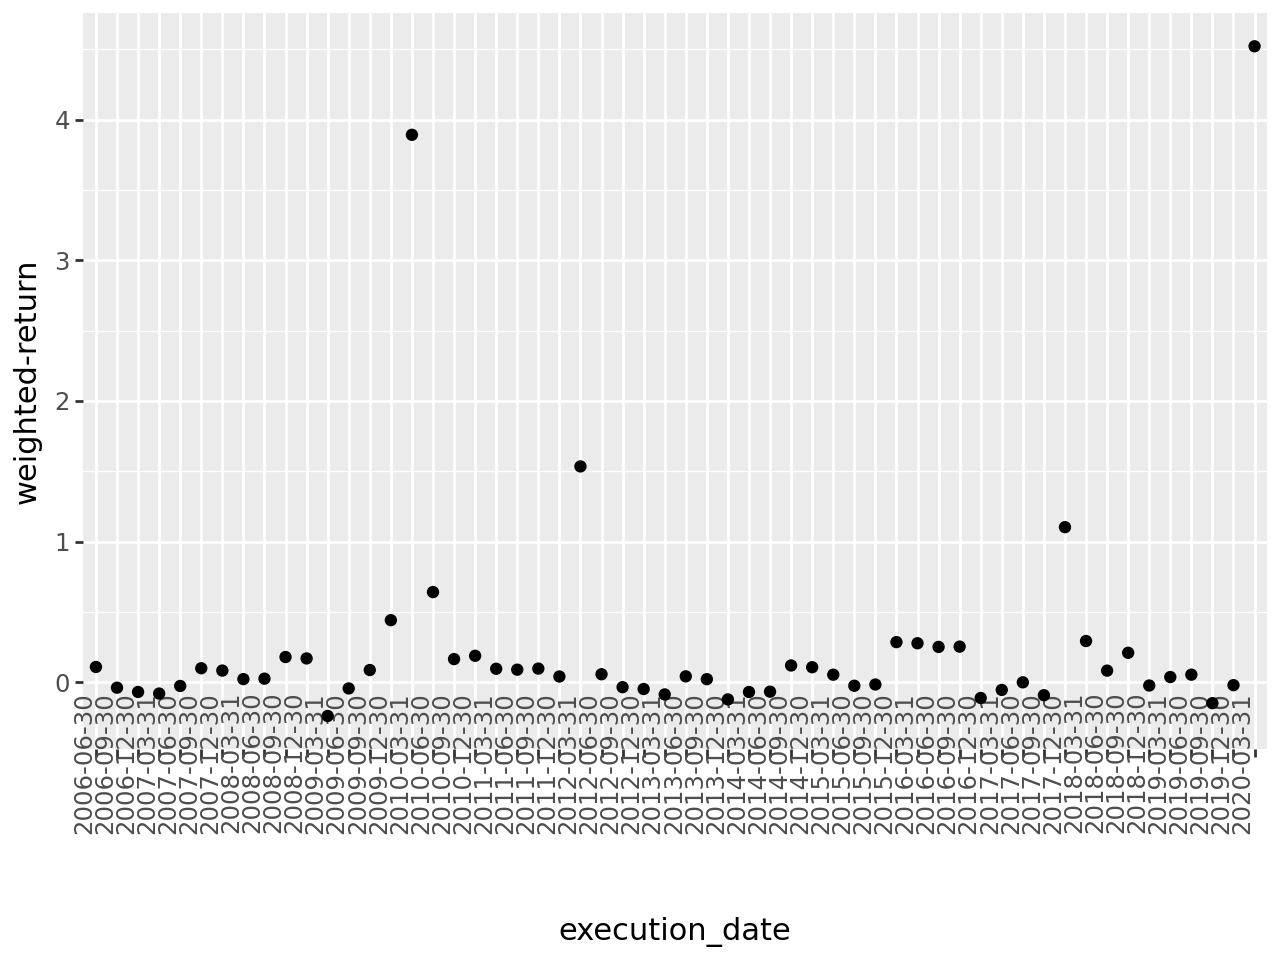

In [168]:
ggplot(test_results_final_tree_pca) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

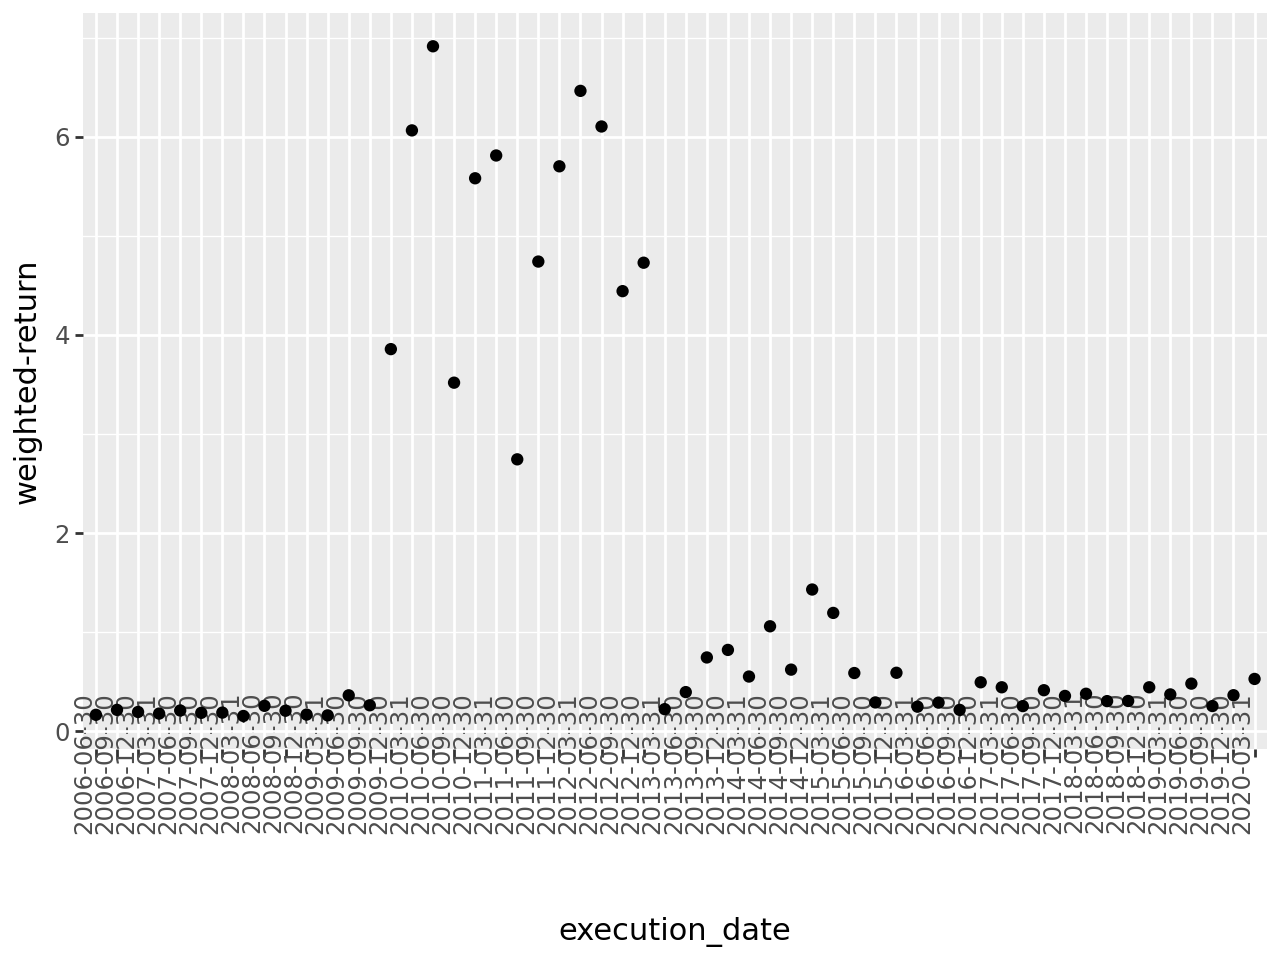

In [169]:
ggplot(train_results_final_tree_pca) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

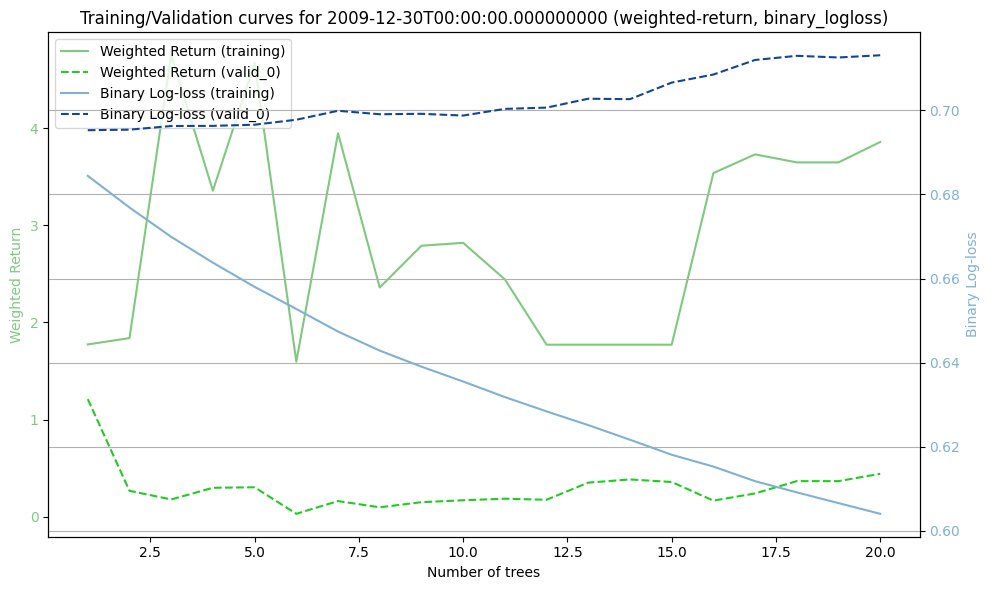

In [193]:
dates = [
     np.datetime64('2009-12-30T00:00:00.000000000')
]
for date in dates:
    model = all_models_pca[date]
    plot_training_curve(
        date,
        all_results_pca
     )

---

In training models, can see that for before 2010 quarters weighted returns in train are very low, models are not fitting well, so in validation they are performing poorly. 

For models after 2010, the lgb are fitting well to train data, giving always +2.5% weighted return

For models after 2019, is happening the same to models before 2010, they aren't fitting well, performing poorly in train data

Lets see some learning curves:

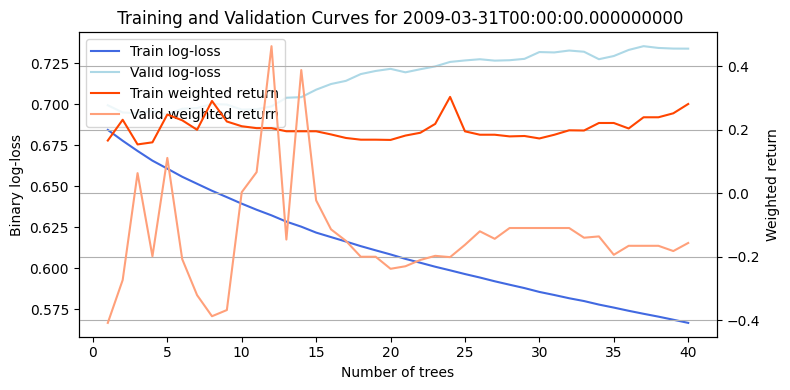

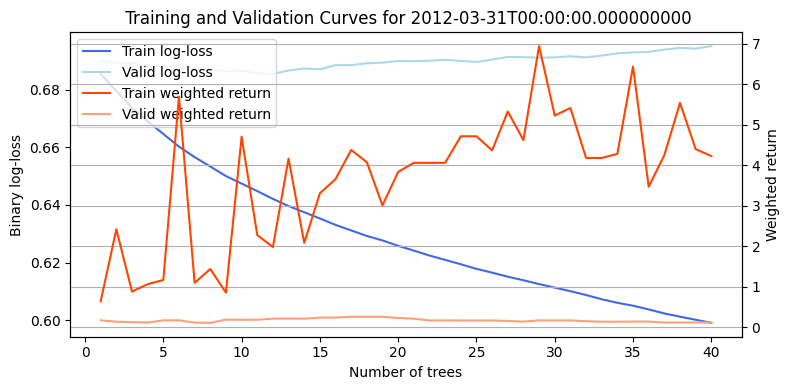

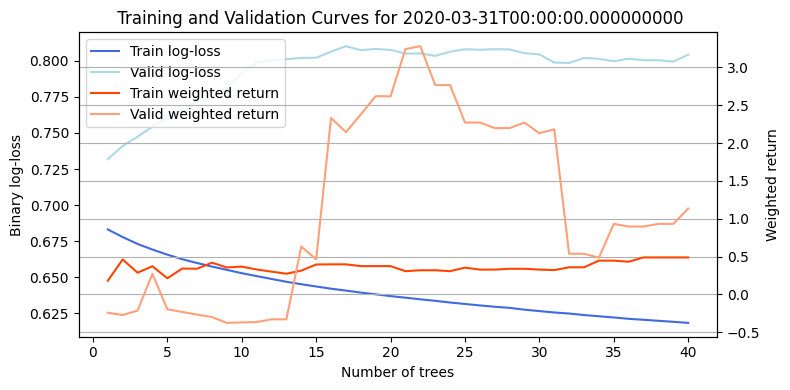

In [128]:
dates = [
     np.datetime64('2009-03-31T00:00:00.000000000'),  # 2009
     np.datetime64('2012-03-31T00:00:00.000000000'),  # 2012
     np.datetime64('2020-03-31T00:00:00.000000000'),  # 2020
]
for date in dates:
    model = all_models[date]
    plot_training_curve(date)


So we can see that something is happening before 2010 and after 2020. Inside both dates the models are fitting well train data.

Despite fitting well train data between 2010 and 2020, only 2 quarter models are giving good predictions

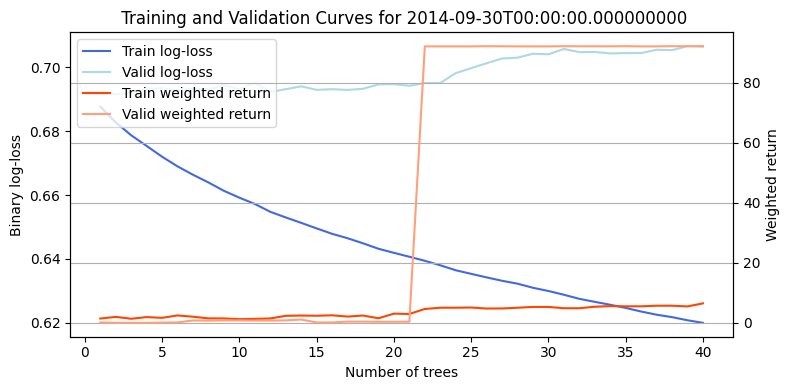

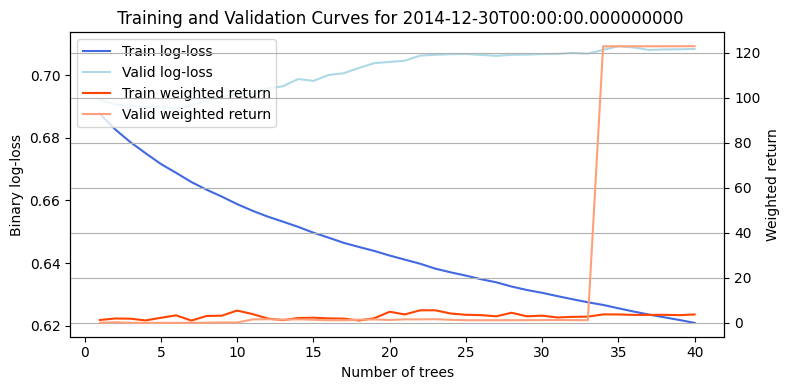

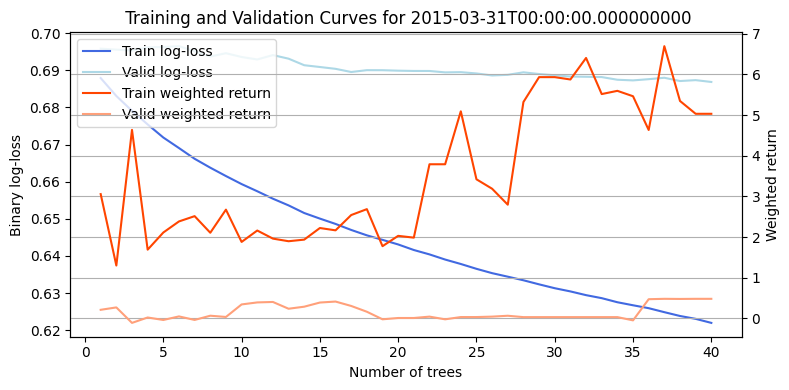

In [129]:
dates = [
     np.datetime64('2014-09-30T00:00:00.000000000'),  # 2014 q3
     np.datetime64('2014-12-30T00:00:00.000000000'),  # 2014 q4
     np.datetime64('2015-03-31T00:00:00.000000000'),  # 2015 q1
]
for date in dates:
    model = all_models[date]
    plot_training_curve(date)


Those 2 models are: 
- 2014 Q3
- 2014 Q4


Giving a +90 weighted return, meaning a `90000%`change. That's no normal!

Let's explore `sp500_change_365` and `stock_change_365` distributions: 

In [48]:
for col in ["sp500_change_365", "stock_change_365"]:
    print(col, "\n ----- \n", data_set[col].describe(percentiles=[.95, .99, .999]))
    print("\n")


sp500_change_365 
 ----- 
 count    156331.000000
mean          0.090628
std           0.161179
min          -0.407895
50%           0.115158
95%           0.290903
99%           0.537782
99.9%         0.537782
max           0.537782
Name: sp500_change_365, dtype: float64


stock_change_365 
 ----- 
 count    156266.000000
mean          0.182812
std           6.749780
min          -0.985119
50%           0.046628
95%           0.995335
99%           2.469490
99.9%         8.312183
max        1217.851571
Name: stock_change_365, dtype: float64




1. `sp500_change_356` looks good, giving the % of change between -0.4 and 0.5.
2. `stock_change_356`of 95% stocks are between -0.9 and 0.99. But we have some very high changes. What is happening?  

For example, a stock change of 10:
  
| price now | price next year | change |
|-----------|----------------|--------|
| 1€        | 11€            | 10     |
| 100€      | 1100€          | 10     |

Both scenarios have the same change, but probably we have some ticker with low values, but a little change in that value, will cause a very high porcentual change


Rows above 10: 115 (0.0675% of the dataset)


,Ticker,execution_date,stock_change_365
87853,TYME,2014-12-30,1217.851571
89604,TYME,2014-12-30,1217.851571
86188,TYME,2014-09-30,919.910076
85104,TYME,2014-09-30,919.910076
82395,TYME,2014-06-30,919.847500
84063,TYME,2014-06-30,919.847500
79708,TYME,2014-03-31,746.511500
35230,AWH,2009-06-30,303.750000
31377,TTNP,2008-12-30,90.200000
154582,MVIS,2020-03-31,76.971014


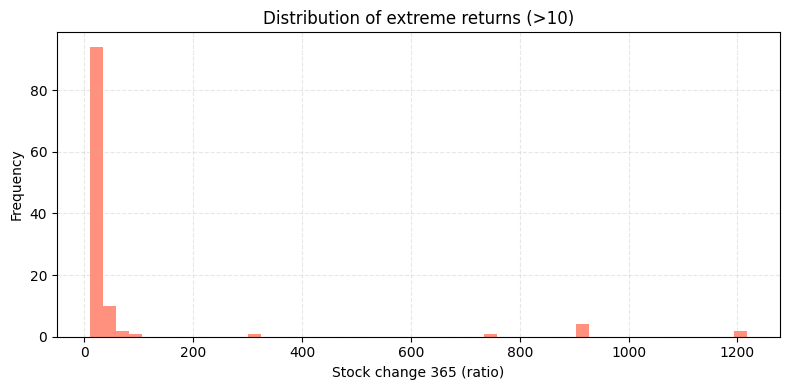

In [49]:
THRESH = 10          # e.g. everything above stocke_change_365 > 10 
outliers = data_set.loc[data_set["stock_change_365"] > THRESH]

print(f"Rows above {THRESH}: {len(outliers):,} "
      f"({len(outliers)/len(data_set):.4%} of the dataset)")

# optional: see the worst offenders
display(outliers.sort_values("stock_change_365", ascending=False)
                 [["Ticker", "execution_date", "stock_change_365"]]
                 .head(20))

# ------- 2. plot only those outliers ---------------------------------
plt.figure(figsize=(8, 4))
plt.hist(outliers["stock_change_365"],
         bins=50,
         color="tomato",
         alpha=0.7)
plt.xlabel("Stock change 365 (ratio)")
plt.ylabel("Frequency")
plt.title(f"Distribution of extreme returns (>{THRESH})")
plt.grid(True, ls="--", alpha=.3)
plt.tight_layout()
plt.show()


In [50]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt